# Multi-Class Image Classification Deep Learning Model for Deepmind 3D Shapes Using TensorFlow
### David Lowe
### June 1, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Deepmind 3D Shapes dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: 3dshapes is a dataset of 3D shapes procedurally generated from six independent latent factors. These factors are floor color, wall color, object color, scale, shape, and orientation. By varying just one latent factor at a time, the researchers were able to generate 480000 images for the dataset.

In this Take1 iteration, we will construct a simple three-layer CNN model to predict the shape in each image.

ANALYSIS: The performance of the baseline model achieved an accuracy score of 99.91% after five epochs using the training dataset. The same model processed the validation dataset with an accuracy score of 99.95%.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Deepmind 3D Shapes dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://github.com/deepmind/3d-shapes

One potential source of performance benchmarks: https://proceedings.mlr.press/v80/kim18b.html

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri May 28 14:18:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.3
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 5
BATCH_SIZE = 64
RAW_IMAGE_SIZE = (64, 64)
TARGET_IMAGE_SIZE = (64, 64)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 4
CLASS_LABELS = [0, 1, 2, 3]
CLASS_NAMES = ['Cube', 'Sphere', 'Cylinder', 'Capsule']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
# TRAIN_DIR = 'staging/'
# VALID_DIR = 'staging/'
# TEST_DIR = 'staging/'
TRAIN_DATASET = '3dshapes.h5'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
!rm 3dshapes.h5
!wget https://dainesanalytics.com/datasets/tensorflow-deepmind-3d-shapes/3dshapes.h5

rm: cannot remove '3dshapes.h5': No such file or directory
--2021-05-28 14:19:01--  https://dainesanalytics.com/datasets/tensorflow-deepmind-3d-shapes/3dshapes.h5
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.211.48, 13.227.211.117, 13.227.211.6, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.211.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267573662 (255M) [application/x-www-form-urlencoded]
Saving to: ‘3dshapes.h5’

3dshapes.h5         100%[===================>] 255.18M   107MB/s    in 2.4s    

2021-05-28 14:19:03 (107 MB/s) - ‘3dshapes.h5’ saved [267573662/267573662]



In [14]:
# load dataset
dataset = h5py.File(TRAIN_DATASET, 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
# image_shape = images.shape[1:]  # [64,64,3]
# label_shape = labels.shape[1:]  # [6]
# n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [15]:
def get_index(factors):
    """ Converts factors to indices in range(num_data)
    Args:
        factors: np array shape [6,batch_size].
                factors[i]=factors[i,:] takes integer values in 
                range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

    Returns:
        indices: np array shape [batch_size].
    """
    indices = 0
    base = 1
    for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
        indices += factors[factor] * base
        base *= _NUM_VALUES_PER_FACTOR[name]
    return indices

In [16]:
def sample_batch(batch_size, fixed_factor, fixed_factor_value):
    """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
        the other factors varying randomly.
    Args:
        batch_size: number of images to sample.
        fixed_factor: index of factor that is fixed in range(6).
        fixed_factor_value: integer value of factor that is fixed 
        in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

    Returns:
        batch: images shape [batch_size,64,64,3]
    """
    factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                        dtype=np.int32)
    for factor, name in enumerate(_FACTORS_IN_ORDER):
        num_choices = _NUM_VALUES_PER_FACTOR[name]
        factors[factor] = np.random.choice(num_choices, batch_size)
    factors[fixed_factor] = fixed_factor_value
    indices = get_index(factors)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])

In [17]:
# Helper function to show images
def show_images_grid(imgs_, num_images=5):
    nrows = int(np.ceil(num_images))
    ncols = int(np.ceil(num_images / nrows))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

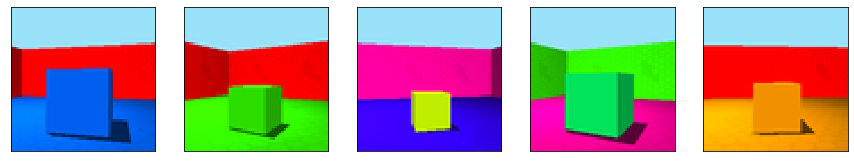

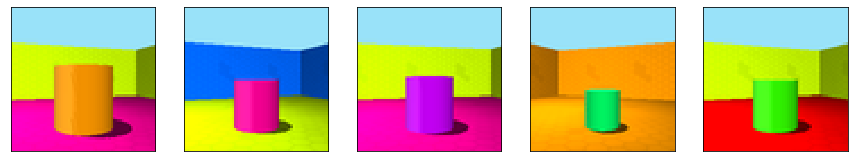

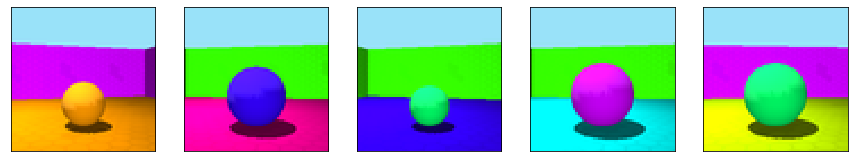

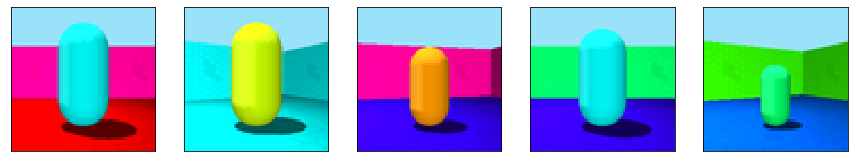

In [18]:
batch_size = 5
fixed_factor_str = 'shape'
for fixed_factor_value in range(4):
    fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)
    img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)
    show_images_grid(img_batch)

In [19]:
# Split the data further into training and validation datasets
images_train, images_valid, labels_train, labels_valid = train_test_split(np.array(images), np.array(labels)[:,4],
                                                                          test_size=VAL_SET_RATIO,
                                                                          stratify=np.array(labels)[:,4],
                                                                          random_state=RNG_SEED)
print("images_train.shape: {} labels_train.shape: {}".format(images_train.shape, labels_train.shape))
print("images_valid.shape: {} labels_valid.shape: {}".format(images_valid.shape, labels_valid.shape))

images_train.shape: (336000, 64, 64, 3) labels_train.shape: (336000,)
images_valid.shape: (144000, 64, 64, 3) labels_valid.shape: (144000,)


In [20]:
class_encoder = preprocessing.LabelBinarizer()
labels_train = class_encoder.fit_transform(labels_train)
print('Training label array shape after encoding:', labels_train.shape)

Training label array shape after encoding: (336000, 4)


In [21]:
labels_valid = class_encoder.transform(labels_valid)
print('Validation label array shape after encoding:', labels_valid.shape)

Validation label array shape after encoding: (144000, 4)


In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=128, conv2_filters=256, conv3_filters=512, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25,
                    input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), activation='relu', kernel_initializer=init_param, input_shape=input_param),
        keras.layers.Conv2D(conv1_filters, (3,3), activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(conv1_dropout),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(conv2_dropout),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), activation='relu', kernel_initializer=init_param),
        # keras.layers.Conv2D(conv3_filters, (3,3), activation='relu', kernel_initializer=init_param),
        # keras.layers.Conv2D(conv3_filters, (3,3), activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(conv3_dropout),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(output_param, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [26]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.00001)
reset_random()
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    images_train, labels_train,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(images_valid, labels_valid),
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/5
5250/5250 [==============================] - 316s 57ms/step - loss: 19.1789 - accuracy: 0.9594 - val_loss: 6.8790e-04 - val_accuracy: 0.9998
Epoch 2/5
5250/5250 [==============================] - 308s 59ms/step - loss: 0.0670 - accuracy: 0.9916 - val_loss: 0.0460 - val_accuracy: 0.9895
Epoch 3/5
5250/5250 [==============================] - 308s 59ms/step - loss: 0.0729 - accuracy: 0.9969 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 4/5
5250/5250 [==============================] - 298s 57ms/step - loss: 0.1075 - accuracy: 0.9983 - val_loss: 1.0762e-11 - val_accuracy: 1.0000
Epoch 5/5
5250/5250 [==============================] - 307s 59ms/step - loss: 0.2033 - accuracy: 0.9991 - val_loss: 0.1983 - val_accuracy: 0.9995
Total time for model fitting: 0:26:26.264972


In [27]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0

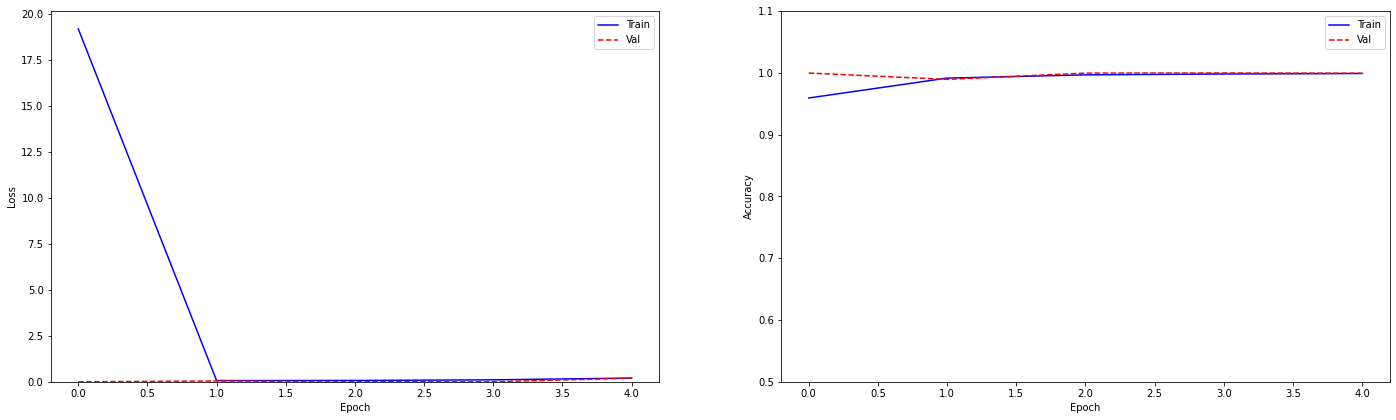

In [28]:
plot_metrics(nn_model_history)

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Not applicable for this iteration of modeling

In [32]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [34]:
# Not applicable for this iteration of modeling

In [35]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [36]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:27:36.091649
